In [1]:
CMAP = "Blues"

# Water Product Interoperability  

Exploiting multi-modal approaches for generating satellite-derived products can offer spatial-temporal advantages of improved completeness, accuracy and precision. 


## Contents
- Baseline Water Product Routines
- Lake George
- Data Availability
- Annual Summaries
- Interoperable Analysis
    - Integrated Annual Summary
    - Acquisitions to Monthly Products
    - Variability
- Future Directions

## Interoperability: areas of investigation

A major caveat to our work is that data fusion and harmonisation at sensor level is not possible due to working with both optical and SAR products. Interoperability must therefore be explored at the 'product' level in a post-classification approach.

To create an 'interoperable' water product we make the following considerations:
- **Availability**: Is there sufficient data within both spatial and temporal dimensions across each sensor.
- **Interpretability**: What does an interoperable product look like?
- **Variability**: How confident can we be in an interoperable product?
- **Temporality**: Creating a meaningful 'integrated' annual water product frequency offered by a multi-modal approach, however what is the maximum temporal frequency that a meaningul water product can be generated at?

Assumptions:
- **Spatial resolution**: working in a cube is fun but means we have to think about the most suitable grid resolution at which to integrate products. We settled on 30m due to being more comfortable with degrading Sentinel-2 and (to a lesser extent) Sentinel-1 than upscaling Landsat-8.
- **Water detection routines**: While some amendments have been made to the classification routines, we assume that outputs for each acquisitions are correct.
- **Temporality**: Monthly intervals seem to demonstrate the highest frequency at which a representative water product can be generated for each sensor. We therefore investigate interoperability at this frequency.


## Baseline Water Product Routines  

Interoperability is explored across three derived water products from `Sentinel 1`, `Sentinel 2` and `Landsat 8`. The classification and associated per-sensor data-exploration is undertaken in separate notebooks referenced below: 

#### Sensor routines

- `Landsat 8`- [link]()    
   The Water Observations From Space(WOFS) algorithm is applied to Landsat8 imagery. WOFS uses a decision tree on surface reflectance features.
   The WOFS routine was run 'out of the box' with no ammendments required.

- `Sentinel 2`- [link]()    
   The Water Observations From Space(WOFS) algorithm is applied to Sentinel 2 imagery. While the original WOFS algorithm was trained and calibrated on Landsat 7 imagery, relatively consistent results are expected from a re-application on Sentinel 2 imagery and are tolerated for the purpose of exploring interoperability.       
    The WOFS routine was ammended for Sentinel-1.

- `Sentinel 1`- [link]()    
   A thresholding algorthim takes advantage of linear class separability on vv and vh bands to classify water.
   Greater amount of work was required to implement a bespoke workflow building upon GA exploratory work.
     
#### Loading the water products & required libraries
   
The outputs of these notebooks are temporarily saved into corressponding `netcdf` files. To properly run this notebook. Ensure that the notebooks listed above have been run.  

The following code imports **required libraries** for this notebook and lists the **paths for three water products** and loads them into the notebook.  

In [2]:
from pathlib import Path
import xarray as xr
# Define dataset file paths
DATA_DIR = Path('output/netcdfs')
DATASETS = {
    'l8': DATA_DIR / 'landsat8_nbar' / 'l8_wofs_product.nc',
    's1': DATA_DIR / 'sentinel_1_gamma' / 's1_water_v2.nc',
    's2': DATA_DIR / 'sentinel_2_ab' / 'wofs_s2ab.nc'
}

datasets = {name: xr.open_dataset(path).sortby('time') for name, path in DATASETS.items()}
print('Loaded datasets: {}'.format(', '.join(datasets.keys())))

Loaded datasets: l8, s1, s2


Each xarray contains a variable called `wofs` that houses water classifications from the classifiers. Values in these xarray assume one of three values. `1`,`0` for water and not-water as well as `nan` values for areas occluded by cloud or are missing data.  

## Lake George

In [3]:
latitudes = (-35.217575569215505, -34.97543887925878) 
longitudes = (149.2719268798828, 149.5095062255859)

In [4]:
from utilities.interactive_maps import display_map
display_map(latitude = latitudes, longitude = longitudes)

### Annual WOFS product

In [5]:
import datacube
dc = datacube.Datacube()  

query = {
'y': (-35.217575569215505, -34.97543887925878), 
'x': (149.2719268798828, 149.5095062255859),
'time':('2017-01-01','2018-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (30, -30)
}

wofs=dc.load(product='wofs_annual_summary', **query)

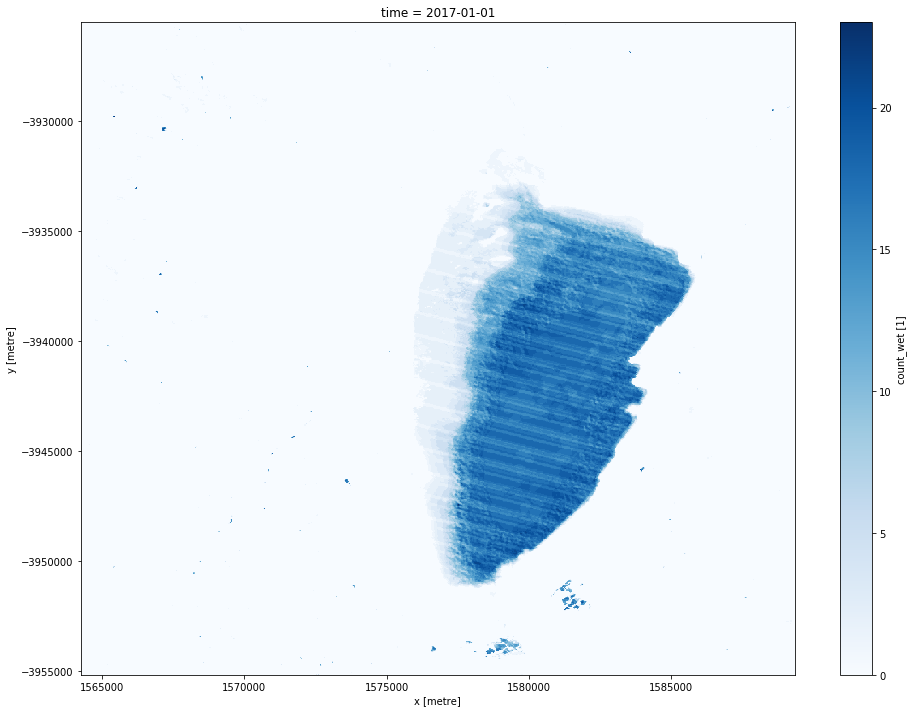

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (16,12))
wofs.count_wet.plot(cmap = "Blues")

### Naive Mixed annual composite

In [7]:
import functools as fct
merged = fct.reduce(lambda ds_a, ds_b: ds_a.merge(ds_b), datasets.values())

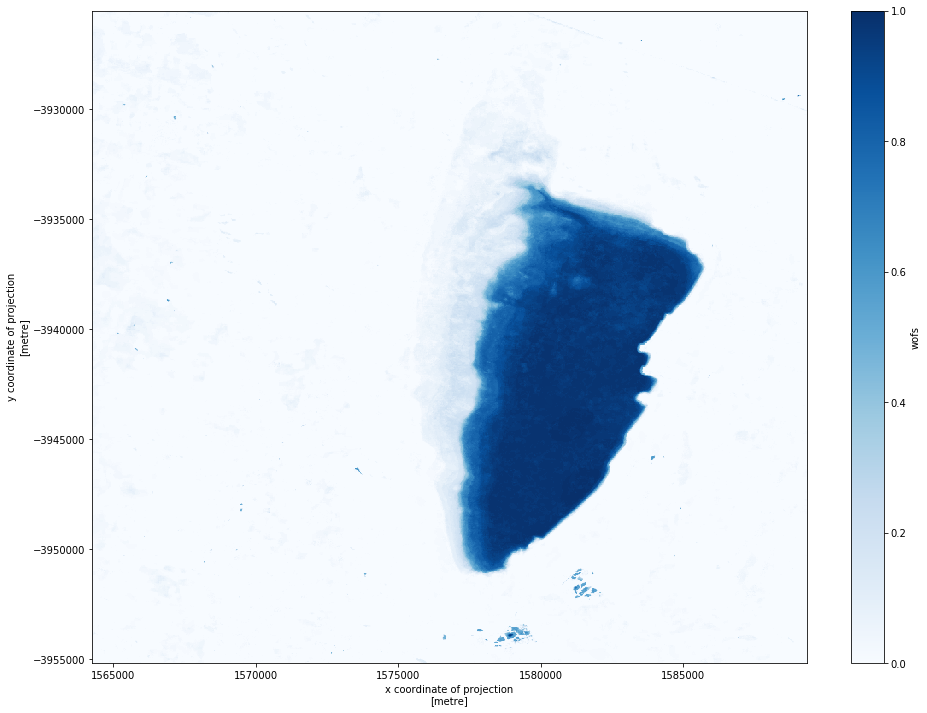

In [8]:
plt.figure(figsize = (16,12))
merged.mean(dim = "time", skipna = True).wofs.plot(cmap = "Blues")

# Exploring water products

In [9]:
from utilities.notebook_animation_widgets import create_movie_on_np_array
import numpy as np 

### Sentinel 2

In [10]:
create_movie_on_np_array(np.flip(datasets["s2"].wofs.values, axis = [1]), text = [*map(str, datasets["s2"].wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


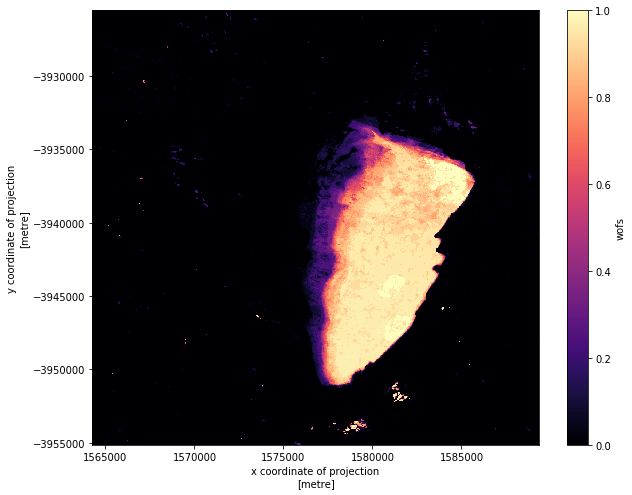

In [11]:
plt.figure(figsize = (10,8))
datasets["s2"].mean(dim = "time", skipna = True).wofs.plot(cmap = "magma")

### Landsat 8

In [12]:
create_movie_on_np_array(np.flip(datasets["l8"].wofs.values,axis = [1]), text = [*map(str, datasets["l8"].wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


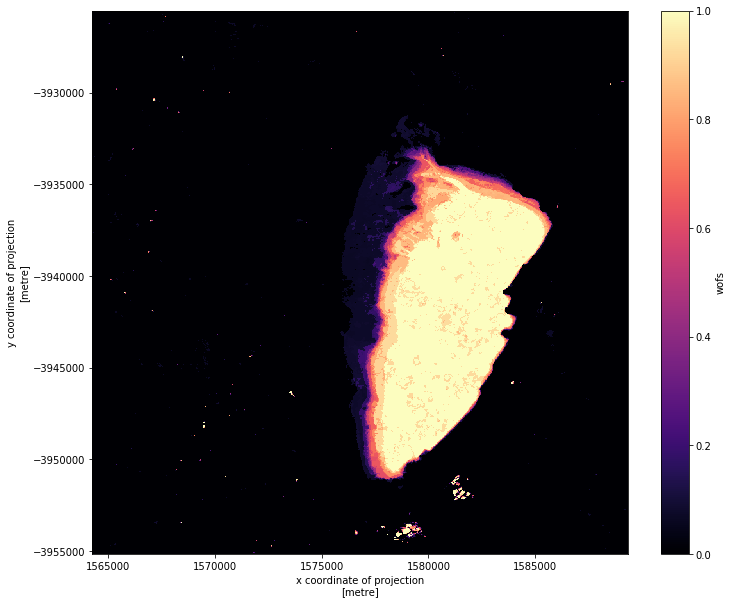

In [13]:
plt.figure(figsize = (12,10))
datasets["l8"].mean(dim = "time", skipna = True).wofs.plot(cmap = "magma")

### Sentinel 1

In [14]:
create_movie_on_np_array(np.flip(datasets["s1"].wofs.values, axis = [1, 2]), text = [*map(str, datasets["s1"].wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


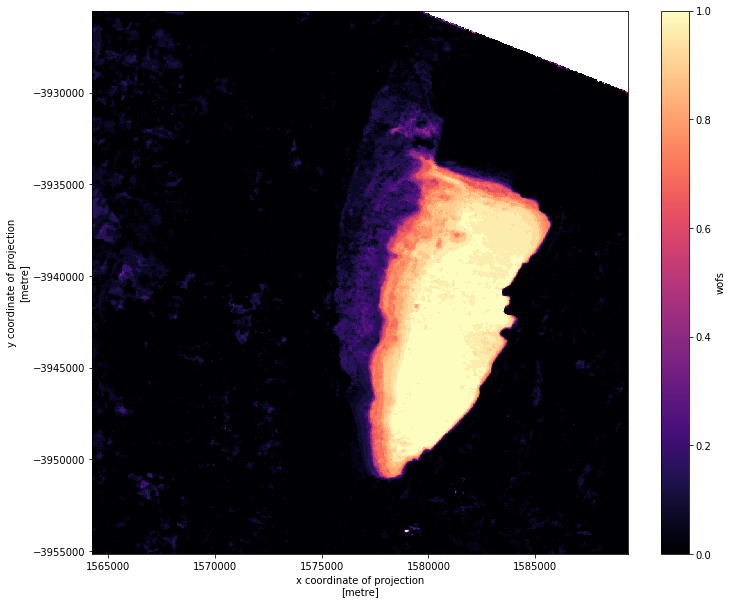

In [15]:
plt.figure(figsize = (12,10))
datasets["s1"].mean(dim = "time", skipna = True).wofs.plot(cmap = "magma")

# Sensor availability  

In [16]:
from utilities.plotting import plot_availability, init_bokeh
init_bokeh()

Loading BokehJS ...

In [17]:
plot_availability(datasets)

## Monthly Temporal Aggregation

In [18]:
fused_resample =merged.resample(time = "M").mean(skipna = True)

### Landsat 8

In [19]:
monthly_l8 = datasets["l8"].resample(time = "M").mean(skipna = True)

In [20]:
create_movie_on_np_array(np.flip(monthly_l8.wofs.values, axis = [1]), text = [*map(str, monthly_l8.wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Sentinel 2

In [21]:
monthly_s2 = datasets["s2"].resample(time = "M").mean(skipna = True)

In [22]:
create_movie_on_np_array(np.flip(monthly_s2.wofs.values, axis = [1]), text = [*map(str, monthly_s2.wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Sentinel 1

In [23]:
monthly_s1 = datasets["s1"].resample(time = "M").mean(skipna = True)

In [24]:
create_movie_on_np_array(np.flip(monthly_s1.wofs.values, axis = [1,2]), text = [*map(str, monthly_s1.wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Fused: Yearly Animation

In [25]:
create_movie_on_np_array(np.flip(merged.wofs.values, axis = [1]),
                         text = [*map(str, merged.wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Fused: Monthly Animation

In [26]:
create_movie_on_np_array(np.flip(fused_resample.wofs.values, axis = [1]), text = [*map(str, monthly_s1.wofs.time.values)], cmap = "magma")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


**Acquisition Count Per Month**

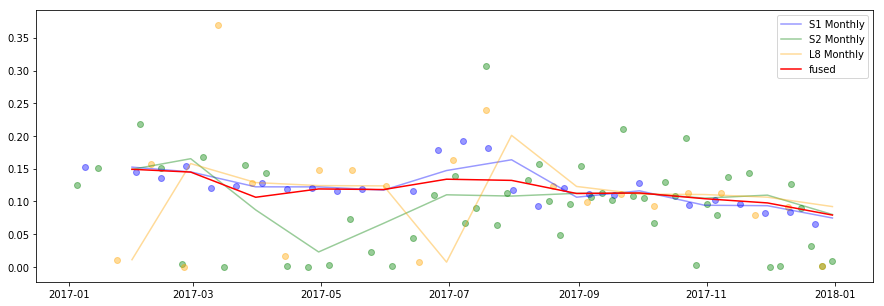

In [27]:
import matplotlib.pyplot as plt  

plt.figure(figsize = (15,5))
plt.plot(monthly_s1.time.values,  monthly_s1.mean(dim = ["x", "y"]).wofs.values, alpha = 0.4, color = "blue", label = "S1 Monthly")
plt.scatter(datasets["s1"].time.values,  datasets["s1"].mean(dim = ["x", "y"]).wofs.values, alpha = 0.4, color = "blue")

plt.plot(monthly_s2.time.values,  monthly_s2.mean(dim = ["x", "y"]).wofs.values, alpha = 0.4, color = "green", label = "S2 Monthly")
plt.scatter(datasets["s2"].time.values,  datasets["s2"].mean(dim = ["x", "y"]).wofs.values, alpha = 0.4, color = "green")

plt.plot(monthly_l8.time.values,  monthly_l8.mean(dim = ["x", "y"]).wofs.values, alpha = 0.4, color = "orange", label = "L8 Monthly")
plt.scatter(datasets["l8"].time.values,  datasets["l8"].mean(dim = ["x", "y"]).wofs.values, alpha = 0.4, color = "orange")


plt.plot(fused_resample.time.values,  fused_resample.mean(dim = ["x", "y"], skipna = True).wofs.values, color = "red", label = "fused")

plt.legend()

# Building an Integrated Profile of Lake George

In [28]:
from utilities.segment import boolean_xarray_min_size_segmentation_filter  
import xarray as xr  

def extract_large_body_from_boolean_xarray( da:xr.DataArray,
                                            frequency_percentile:float = 0.0625,
                                            min_number_of_pixels:int = 1000):

    body = (da.mean(dim = "time") > frequency_percentile)
    return boolean_xarray_min_size_segmentation_filter(body, min_size= min_number_of_pixels)    

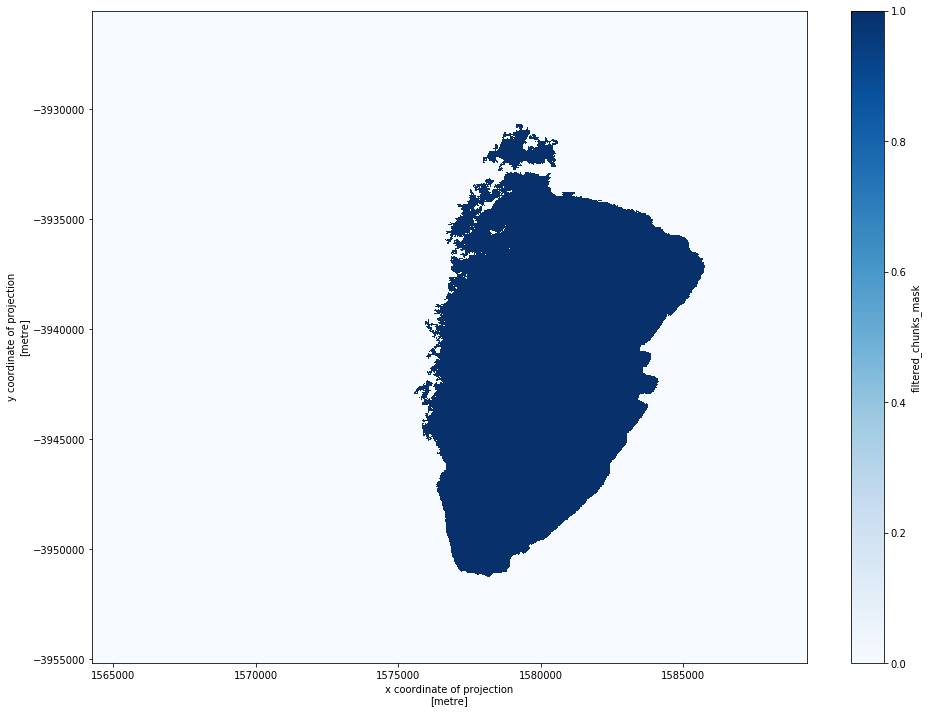

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (16,12))
extract_large_body_from_boolean_xarray(merged.wofs).plot(cmap = CMAP)

In [30]:
george = extract_large_body_from_boolean_xarray(merged.wofs)

In [31]:
filtered_datasets = {key: datasets[key].where(george) for key in datasets.keys()}